In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:

def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    action = np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    
    #if word == 'aargh':
    #    print(f'recons', action, history, guesses)
    return action   
    

def construct_action_vectors_global(arg): #guesses, history, start_idx, end_idx):
    st = time.time()
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    ret = np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    #print(f'construct_actions_global took {time.time() - st}')
    return ret
           
def construct_action_vectors(guesses, history, df):
        return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iterrows()])
    
NUM_PROCESSES = mp.cpu_count() - 1
def construct_action_vectors_mp(guesses, history, df):
        grp_lst_args = []
        grp_guesses = [guesses] * NUM_PROCESSES
        grp_history = [history] * NUM_PROCESSES
        
        chunk_size = int(len(df) / NUM_PROCESSES) + 1
        start_offsets = list(range(0, len(df), chunk_size))
        end_offsets = start_offsets[1:] + [len(df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        pool = mp.Pool(processes=NUM_PROCESSES)
        results = pool.map(construct_action_vectors_global, grp_lst_args)
        pool.close()
        pool.join()
        return np.concatenate(results)
    
    
def construct_state_vector(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        return np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))


    

   
so the state is going to be:
* The number of green locations we know
*  The number of other letters we know to be in the word
*  The number of letters we know to not be in the word
*  The sequence number of the guess (1st guess, 2nd guess etc.)

the action is going to be a word that we will submit next
for the purposes of feeding into the model, we will represent the action word as:
*  whether or not it conforms to the hint history
*  how many new letters it gives us
*  the number of uniq letters in the word
*  the frequency of the letters in the word

the reward is going to be:
*  the score improvement (if any) gained on the last guess
*  the score will be calculated as 2 * num_green_letters + num_orange_letters

In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
#Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 9
n_input_features = n_action_features + n_state_features


def select_action(policy_net, state, actions, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            #print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)



def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [7]:
class DQN(nn.Module):

    def __init__(self, inputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 20)
        self.head = nn.Linear(20, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.head(x)

In [8]:
class LinearQ(nn.Module):

    def __init__(self, inputs):
        super(LinearQ, self).__init__()
        self.head = nn.Linear(inputs, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return self.head(x)

In [32]:
def optimize_model(model, optimizer, memory, batch_size=128):

    transitions = memory.sample(batch_size)

    #for tr in transitions:
    #    print(list(tr.state), list(tr.action), tr.reward)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
      
    reward_batch = np.stack([tr.reward for tr in transitions])
    state_action_batch = np.concatenate((state_batch, action_batch), axis=1)
    
    #print(reward_batch)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_value_estimates = model(torch.tensor(state_action_batch, device=device, dtype=torch.float))
    #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
       
    expected_state_action_values = torch.tensor(reward_batch, device=device, dtype=torch.float)
    # Compute Huber loss
    print('loss shapes')
    print(state_action_value_estimates.shape)
    print(expected_state_action_values.shape)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_value_estimates, expected_state_action_values)
    
    print(f'loss {loss}')

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    #for param in model.parameters():
        #param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [33]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128),
                   seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    EPS_START = eps[0]
    EPS_END = eps[1]
    EPS_DECAY = eps[2]
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_actions = construct_action_vectors(env.guesses, env.history, env.df)
    starting_state = construct_state_vector(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    if model.name == 'linear':
        policy_net = LinearQ(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        policy_net = DQN(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)

    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        actions = starting_actions
        guesses = []
        for t in count():
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            
            epsilons.append(eps)
            #print(epsilons)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state)
            action_idx = select_action(policy_net, state, actions, eps)
            selected_action = actions[action_idx]
            #print(action_idx, selected_action)
            guesses.append(env.word_from_index(action_idx))
            print(f'------guess {t} {action_idx} {guesses[-1]} {selected_action}-------')
            
            history, reward, done = env.step_by_index(action_idx)
            #here next_state == env.history
            if not done:
                next_state = construct_state_vector(guesses, history)
                actions = construct_action_vectors_mp(guesses, history, env.df)
            
            print(f'reward {reward} done {done} ')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, selected_action, reward)
            episode_memory.append([state, selected_action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                scores = history.sum(axis=1) # calc the score for each guess from the history
                episode_reward = sum(tr[2] for tr in episode_memory)
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                # reward[i] = max(0, scores[i] - max(scores[0:i-1]))
                
                for i,tr in enumerate(episode_memory):
                    if i == 0:
                        score = scores[i]
                    else:
                        score = max(0, scores[i] - scores[0:i].max())
                    print(f'{guesses[i]} {history[i]} {score}')    
                
                    memory.push(tr[0], tr[1], [score])
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done - last_training > training.train_interval:
                    loss = optimize_model(policy_net, optimizer, memory, batch_size=training.batch_size)
                    losses.append(loss)
                    if training.clear_memory: memory.clear()
                    last_training = steps_done
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward -1 done True

reward -1 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward -1 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward -1 done True 
episode 8 finished.  reward -6  eps 0.0  gamma 0.0  steps 54  memory 48
jumpy [0. 0. 0. 0. 2.] 2.0
gawky [0. 0. 0. 0. 2.] 0
jumpy [0. 0. 0. 0. 2.] 0
gawky [0. 0. 0. 0. 2.] 0
jumpy [0. 0. 0. 0. 2.] 0
gawky [0. 0. 0. 0. 2.] 0
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
reward -1 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward -1 done False 
------guess 3 11260 

reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 10837 using [1.         0.4        0.43682076 0.         0.        ]-------
reward 0 done True 
episode 11 finished.  reward -2  eps 0.0  gamma 0.0  steps 69  memory 66
later [0. 0. 0. 0. 0.] 0.0
sonic [1. 0. 1. 1. 0.] 3.0
using [2. 2. 2. 2. 2.] 7.0
=========================episode 12 piece======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 12560 imbue [1.         0.6        0.48142741 0.         0.        ]-------
reward -1 done False 
------guess 3 12920 piece [1.         0.4        0.64574209 0.33333333 0.        ]-------
reward 0 done True 
episode 12 finished.  reward -3  eps 0.0  gamma 0.0  steps 73  memory 69
later [0. 0. 0. 1. 

reward -1 done False 
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 12821 rotor [1.         0.4        0.65450122 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 4 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done True 
episode 16 finished.  reward -6  eps 0.0  gamma 0.0  steps 91  memory 85
mamma [0. 0. 0. 0. 0.] 0.0
eerie [0. 0. 1. 0. 0.] 1.0
rotor [1. 1. 0. 0. 0.] 1.0
mamma [0. 0. 0. 0. 0.] 0
mamma [0. 0. 0. 0. 0.] 0
mamma [0. 0. 0. 0. 0.] 0
=========================episode 17 chase======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 

reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 1610 chuse [1.         0.6        0.52473642 0.         1.        ]-------
reward -1 done False 
------guess 3 12731 geese [1.         0.2        0.75896188 0.66666667 0.        ]-------
reward 0 done True 
episode 19 finished.  reward -3  eps 0.0  gamma 0.0  steps 107  memory 103
later [0. 0. 0. 1. 0.] 1.0
noise [0. 0. 0. 2. 2.] 3.0
chuse [0. 0. 0. 2. 2.] 0
geese [2. 2. 2. 2. 2.] 6.0
=========================episode 20 hippo======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11220 opium [1.         0.6        0.41768045 0.         0.        ]-------
reward -1 done False 
------guess 3 12113 hippo [1.         0.2        0.41330089 0.33

reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11680 dingo [1.         0.4        0.43860503 0.         0.        ]-------
reward 0 done True 
episode 23 finished.  reward -2  eps 0.0  gamma 0.0  steps 123  memory 120
later [0. 0. 0. 0. 0.] 0.0
sonic [0. 1. 2. 1. 0.] 4.0
dingo [2. 2. 2. 2. 2.] 6.0
=========================episode 24 grace======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11909 arose [1.         0.4        0.73544201 0.         0.        ]-------
reward -1 done False 
------guess 2 12386 crane [1.         0.4        0.67526358 0.         0.        ]-------
reward -1 done False 
------guess 3 11299 grace [1.        0.2       0.6324412 0.        0.       ]-------
reward 0 done True 
episode 24 finished.  reward -3  eps 0.0  gamma 0.0  steps 127  memory 123
later [0. 1. 0. 1. 1

reward -1 done False 
------guess 1 12350 older [1.         0.4        0.64849959 0.         0.        ]-------
reward -1 done False 
------guess 2 11375 plier [1.         0.4        0.63081914 0.         0.        ]-------
reward -1 done False 
------guess 3 11415 flier [1.         0.2        0.60859692 0.         0.        ]-------
reward 0 done True 
episode 28 finished.  reward -3  eps 0.0  gamma 0.0  steps 143  memory 139
later [1. 0. 0. 2. 2.] 5.0
older [0. 2. 0. 2. 2.] 1.0
plier [0. 2. 2. 2. 2.] 2.0
flier [2. 2. 2. 2. 2.] 2.0
=========================episode 29 flesh======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12737 close [1.         0.6        0.62481752 0.         0.        ]-------
reward -1 done False 
------guess 2 10710 flesh [1.         0.4        0.52554745 0.         0.        ]-------
reward 0 done True 
episode 29 finished.  reward -2  eps 0.0  gamma 0.0  steps 146 

reward -1 done False 
------guess 1 12067 lyric [1.         0.6        0.51759935 0.         0.        ]-------
reward -1 done False 
------guess 2 12806 lorry [1.         0.2        0.59951338 0.33333333 0.        ]-------
reward 0 done True 
episode 33 finished.  reward -2  eps 0.0  gamma 0.0  steps 164  memory 161
later [2. 0. 0. 0. 1.] 3.0
lyric [2. 1. 2. 0. 0.] 2.0
lorry [2. 2. 2. 2. 2.] 5.0
=========================episode 34 trait======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11767 roast [1.         0.4        0.65369019 0.         0.        ]-------
reward -1 done False 
------guess 2 12580 grant [1.         0.4        0.56658556 0.         0.        ]-------
reward -1 done False 
------guess 3 12449 craft [1.         0.4        0.53755069 0.         0.        ]-------
reward -1 done False 
------guess 4 11019 trait [1.         0.2        0.64995945 0.33333333 0.        ]------

reward -1 done False 
------guess 1 11316 arson [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 11807 diary [1.         0.6        0.54614761 0.         0.        ]-------
reward -1 done False 
------guess 3 12368 chard [1.         0.4        0.50884023 0.         0.        ]-------
reward 0 done True 
episode 37 finished.  reward -3  eps 0.0  gamma 0.0  steps 182  memory 178
later [0. 1. 0. 0. 1.] 2.0
arson [1. 1. 0. 0. 0.] 0
diary [1. 0. 2. 2. 0.] 3.0
chard [2. 2. 2. 2. 2.] 5.0
=========================episode 38 heart======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11529 irate [1.         0.2        0.73171127 0.         0.        ]-------
reward -1 done False 
------guess 2 10685 react [1.         0.2        0.70024331 0.         0.        ]-------
reward -1 done False 
------guess 3 11313 heart [1.         0.2        0.68596918 0. 

reward -1 done False 
------guess 1 10929 cater [1.         0.2        0.70024331 0.         0.        ]-------
reward -1 done False 
------guess 2 11364 hater [1.         0.2        0.68596918 0.         0.        ]-------
reward 0 done True 
episode 42 finished.  reward -2  eps 0.0  gamma 0.0  steps 201  memory 198
later [0. 2. 2. 2. 2.] 8.0
cater [0. 2. 2. 2. 2.] 0
hater [2. 2. 2. 2. 2.] 2.0
=========================episode 43 cigar======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12523 sonar [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 10657 cigar [1.         0.6        0.54128143 0.         0.        ]-------
reward 0 done True 
episode 43 finished.  reward -2  eps 0.0  gamma 0.0  steps 204  memory 201
later [0. 1. 0. 0. 2.] 3.0
sonar [0. 0. 0. 2. 2.] 1.0
cigar [2. 2. 2. 2. 2.] 6.0
=========================episode 44 biddy=======

reward -1 done False 
------guess 1 11449 mason [1.         0.8        0.53414436 0.         0.        ]-------
reward -1 done False 
------guess 2 10867 panic [1.         0.6        0.49781022 0.         0.        ]-------
reward 0 done True 
episode 48 finished.  reward -2  eps 0.0  gamma 0.0  steps 220  memory 217
later [0. 2. 0. 0. 0.] 2.0
mason [0. 2. 0. 0. 1.] 1.0
panic [2. 2. 2. 2. 2.] 7.0
=========================episode 49 bloat======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12917 tonal [1.         0.4        0.60924574 0.         0.        ]-------
reward -1 done False 
------guess 2 11033 gloat [1.         0.2        0.56642336 0.         0.        ]-------
reward -1 done False 
------guess 3 11880 bloat [1.         0.2        0.56155718 0.         0.        ]-------
reward 0 done True 
episode 49 finished.  reward -3  eps 0.0  gamma 0.0  steps 224  memory 220
later [1. 1. 1.

reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 12378 gumbo [1.         0.8        0.34533658 0.         0.        ]-------
reward -1 done False 
------guess 3 11664 buxom [1.         0.2        0.30089213 0.         0.        ]-------
reward 0 done True 
episode 53 finished.  reward -3  eps 0.0  gamma 0.0  steps 239  memory 235
later [0. 0. 0. 0. 0.] 0.0
sonic [0. 1. 0. 0. 0.] 1.0
gumbo [0. 2. 1. 1. 1.] 4.0
buxom [2. 2. 2. 2. 2.] 5.0
=========================episode 54 singe======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 11558 since [1.         0.2        0.58799676 0.         0.        ]-------
reward -1 done False 
------guess 3 11285 singe [1.         0.2        0.56107056 0

reward -1 done False 
------guess 1 10745 lusty [1.         0.6        0.48807786 0.         0.        ]-------
reward -1 done False 
------guess 2 10883 light [1.         0.6        0.45725872 0.         0.        ]-------
reward 0 done True 
episode 57 finished.  reward -2  eps 0.0  gamma 0.0  steps 255  memory 252
later [2. 0. 1. 0. 0.] 3.0
lusty [2. 0. 0. 1. 0.] 0
light [2. 2. 2. 2. 2.] 7.0
=========================episode 58 rinse======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 12711 rinse [1.         0.2        0.65644769 0.         0.        ]-------
reward 0 done True 
episode 58 finished.  reward -2  eps 0.0  gamma 0.0  steps 258  memory 255
later [0. 0. 0. 1. 1.] 2.0
snore [1. 1. 0. 1. 2.] 3.0
rinse [2. 2. 2. 2. 2.] 5.0
=========================episode 59 denim=======

reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11093 hunky [1.        0.8       0.3351176 0.        0.       ]-------
reward -1 done False 
------guess 3 12475 funky [1.         0.2        0.30932685 0.         0.        ]-------
reward 0 done True 
episode 62 finished.  reward -3  eps 0.0  gamma 0.0  steps 275  memory 271
later [0. 0. 0. 0. 0.] 0.0
sonic [0. 0. 2. 0. 0.] 2.0
hunky [0. 2. 2. 2. 2.] 6.0
funky [2. 2. 2. 2. 2.] 2.0
=========================episode 63 humus======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11362 pushy [1.         0.8        0.37583131 0.         0.        ]-------
reward -1 done False 
------guess 3 12214 humus [1.         0.2        0.37437145 0.3333

reward -1 done False 
------guess 1 12523 sonar [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 10657 cigar [1.         0.6        0.54128143 0.         0.        ]-------
reward -1 done False 
------guess 3 10792 briar [1.         0.2        0.60486618 0.33333333 0.        ]-------
reward -1 done False 
------guess 4 11685 friar [1.         0.2        0.59659367 0.33333333 0.        ]-------
reward 0 done True 
episode 67 finished.  reward -4  eps 0.0  gamma 0.0  steps 294  memory 289
later [0. 1. 0. 0. 2.] 3.0
sonar [0. 0. 0. 2. 2.] 1.0
cigar [0. 1. 0. 2. 2.] 1.0
briar [0. 2. 2. 2. 2.] 3.0
friar [2. 2. 2. 2. 2.] 2.0
=========================episode 68 drain======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11316 arson [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 10720 drain [1.     

reward -1 done False 
------guess 1 11822 piano [1.         0.8        0.54274128 0.         0.        ]-------
reward -1 done False 
------guess 2 11307 ninja [1.         0.2        0.45855637 0.33333333 0.        ]-------
reward 0 done True 
episode 72 finished.  reward -2  eps 0.0  gamma 0.0  steps 309  memory 306
later [0. 1. 0. 0. 0.] 1.0
piano [0. 2. 1. 1. 0.] 3.0
ninja [2. 2. 2. 2. 2.] 6.0
=========================episode 73 knife======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 12873 whine [1.         0.4        0.49683698 0.         0.        ]-------
reward -1 done False 
------guess 3 11712 knife [1.         0.4        0.47347932 0.         0.        ]-------
reward 0 done True 
episode 73 finished.  reward -3  eps 0.0  gamma 0.0  steps 313  memory 309
later [0. 0. 0.

reward -1 done False 
------guess 1 11249 canoe [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 11945 cause [1.         0.4        0.62043796 0.         0.        ]-------
reward -1 done False 
------guess 3 11994 cache [1.         0.2        0.57664234 0.33333333 0.        ]-------
reward 0 done True 
episode 77 finished.  reward -3  eps 0.0  gamma 0.0  steps 329  memory 325
later [0. 2. 0. 1. 0.] 3.0
canoe [2. 2. 0. 0. 2.] 3.0
cause [2. 2. 0. 0. 2.] 0
cache [2. 2. 2. 2. 2.] 4.0
=========================episode 78 serif======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 12750 serif [1.         0.4        0.60048662 0.         0.        ]-------
reward 0 done True 
episode 78 finished.  reward -2  eps 0.0  gamma 0.0  steps 332  m

reward -1 done False 
------guess 1 12003 renal [1.         0.2        0.71451744 0.         0.        ]-------
reward -1 done False 
------guess 2 11913 glare [1.         0.2        0.67169505 0.         0.        ]-------
reward -1 done False 
------guess 3 12270 blare [1.         0.2        0.66682887 0.         0.        ]-------
reward -1 done False 
------guess 4 12654 flare [1.         0.2        0.65855637 0.         0.        ]-------
reward 0 done True 
episode 82 finished.  reward -4  eps 0.0  gamma 0.0  steps 350  memory 345
later [1. 1. 0. 1. 1.] 4.0
renal [1. 1. 0. 1. 1.] 0
glare [0. 2. 2. 2. 2.] 4.0
blare [0. 2. 2. 2. 2.] 0
flare [2. 2. 2. 2. 2.] 2.0
=========================episode 83 tilde======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11875 stole [1.         0.4        0.66569343 0.         0.        ]-------
reward -1 done False 
------guess 2 11340 elite [1.         

reward -1 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward -1 done False 
------guess 2 11374 ghost [1.         0.4        0.46261152 0.         0.        ]-------
reward -1 done False 
------guess 3 10854 boost [1.         0.2        0.51695053 0.33333333 0.        ]-------
reward 0 done True 
episode 86 finished.  reward -3  eps 0.0  gamma 0.0  steps 368  memory 364
later [0. 0. 1. 0. 0.] 1.0
stoic [1. 1. 2. 0. 0.] 3.0
ghost [0. 0. 2. 2. 2.] 2.0
boost [2. 2. 2. 2. 2.] 4.0
=========================episode 87 steal======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11185 stale [1.         0.2        0.70218978 0.         0.        ]-------
reward -1 done False 
------guess 2 11656 steal [1.         0.         0.70218978 0.         0.        ]-------
reward 0 done True 
episode 87 finished.  reward -2  eps 0.0  gamma 0.0  steps 371 

reward -1 done False 
------guess 1 11537 solid [1.         0.8        0.52003244 0.         0.        ]-------
reward -1 done False 
------guess 2 12541 scowl [1.         0.4        0.45644769 0.         0.        ]-------
reward -1 done False 
------guess 3 12530 sloop [1.         0.2        0.52927818 0.33333333 0.        ]-------
reward -1 done False 
------guess 4 10936 slosh [1.         0.2        0.51905921 0.33333333 0.        ]-------
reward 0 done True 
episode 91 finished.  reward -4  eps 0.0  gamma 0.0  steps 388  memory 383
later [1. 0. 0. 0. 0.] 1.0
solid [2. 1. 1. 0. 0.] 3.0
scowl [2. 0. 2. 0. 1.] 1.0
sloop [2. 2. 2. 0. 0.] 1.0
slosh [2. 2. 2. 2. 2.] 4.0
=========================episode 92 novel======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12338 olden [1.         0.6        0.59594485 0.         0.        ]-------
reward -1 done False 
------guess 2 12061 novel [1.     

reward -1 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 12489 hyena [1.         0.4        0.58410381 0.         0.        ]-------
reward 0 done True 
episode 96 finished.  reward -2  eps 0.0  gamma 0.0  steps 406  memory 403
later [0. 1. 0. 1. 0.] 2.0
ocean [0. 0. 2. 1. 1.] 2.0
hyena [2. 2. 2. 2. 2.] 6.0
=========================episode 97 apply======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward -1 done False 
------guess 2 11182 aloud [1.         0.6        0.53722628 0.         0.        ]-------
reward -1 done False 
------guess 3 11452 amply [1.         0.6        0.45515004 0.         0.        ]-------
reward -1 done False 
------guess 4 11850 apply [1.         0.         0.46342255 0.33333333 0.        ]------

reward -1 done False 
------guess 1 11828 ramen [1.         0.4        0.64914842 0.         0.        ]-------
reward -1 done False 
------guess 2 11630 harem [1.        0.2       0.6189781 0.        0.       ]-------
reward 0 done True 
episode 101 finished.  reward -2  eps 0.0  gamma 0.0  steps 423  memory 420
later [0. 2. 0. 2. 1.] 5.0
ramen [1. 2. 1. 2. 0.] 1.0
harem [2. 2. 2. 2. 2.] 4.0
=========================episode 102 bilge======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12737 close [1.         0.6        0.62481752 0.         0.        ]-------
reward -1 done False 
------guess 2 11245 guile [1.         0.6        0.55166261 0.         0.        ]-------
reward -1 done False 
------guess 3 11580 bilge [1.        0.2       0.5214923 0.        0.       ]-------
reward 0 done True 
episode 102 finished.  reward -3  eps 0.0  gamma 0.0  steps 427  memory 423
later [1. 0. 0. 1. 0.]

reward -1 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward -1 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward -1 done False 
------guess 3 12115 drier [1.         0.2        0.66423358 0.33333333 0.        ]-------
reward 0 done True 
episode 106 finished.  reward -3  eps 0.0  gamma 0.0  steps 443  memory 439
later [0. 0. 0. 2. 2.] 4.0
poser [0. 0. 0. 2. 2.] 0
nicer [0. 1. 0. 2. 2.] 1.0
drier [2. 2. 2. 2. 2.] 5.0
=========================episode 107 punch======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 12840 punch [1.         0.6        0.36901865 0.         0.        ]-------
reward 0 done True 
episode 107 finished.  reward -2  eps 0.0  gamma 0.0  steps 446

reward -1 done False 
------guess 1 12567 stone [1.         0.6        0.64233577 0.         0.        ]-------
reward -1 done False 
------guess 2 12640 quote [1.         0.4        0.52100568 0.         0.        ]-------
reward 0 done True 
episode 111 finished.  reward -2  eps 0.0  gamma 0.0  steps 459  memory 456
later [0. 0. 1. 1. 0.] 2.0
stone [0. 1. 2. 0. 2.] 3.0
quote [2. 2. 2. 2. 2.] 5.0
=========================episode 112 krill======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11912 broil [1.         0.6        0.53917275 0.         0.        ]-------
reward -1 done False 
------guess 2 12482 drill [1.         0.2        0.55166261 0.33333333 0.        ]-------
reward -1 done False 
------guess 3 12030 grill [1.         0.2        0.53836172 0.33333333 0.        ]-------
reward -1 done False 
------guess 4 12538 frill [1.         0.2        0.52522303 0.33333333 0.        ]----

reward -1 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward -1 done False 
------guess 2 11362 pushy [1.         0.8        0.37583131 0.         0.        ]-------
reward -1 done False 
------guess 3 11650 husky [1.         0.2        0.35036496 0.         0.        ]-------
reward 0 done True 
episode 117 finished.  reward -3  eps 0.0  gamma 0.0  steps 480  memory 476
later [0. 0. 0. 0. 0.] 0.0
sonic [1. 0. 0. 0. 0.] 1.0
pushy [0. 2. 2. 1. 2.] 6.0
husky [2. 2. 2. 2. 2.] 3.0
=========================episode 118 reach======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11909 arose [1.         0.4        0.73544201 0.         0.        ]-------
reward -1 done False 
------guess 2 10719 yearn [1.         0.4        0.66682887 0.         0.        ]-------
reward -1 done False 
------guess 3 12034 reach [1.         0.4        0.64509327

reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 12091 urine [1.         0.4        0.62368208 0.         0.        ]-------
reward 0 done True 
episode 122 finished.  reward -2  eps 0.0  gamma 0.0  steps 499  memory 496
later [0. 0. 0. 1. 1.] 2.0
snore [0. 1. 0. 1. 2.] 2.0
urine [2. 2. 2. 2. 2.] 6.0
=========================episode 123 bland======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward -1 done False 
------guess 2 12846 clang [1.         0.4        0.49651257 0.         0.        ]-------
reward -1 done False 
------guess 3 11060 bland [1.         0.4        0.47802109 0.         0.        ]-------
reward 0 done True 
episode 123 finished.  reward -3  eps 0.0  gamma 0.0  steps 503  memory 499
later [1. 1.

reward -1 done False 
------guess 1 12315 aisle [1.         0.4        0.69278183 0.         0.        ]-------
reward -1 done False 
------guess 2 12349 scale [1.         0.2        0.66131387 0.         0.        ]-------
reward -1 done False 
------guess 3 12200 shale [1.         0.2        0.64703974 0.         0.        ]-------
reward 0 done True 
episode 127 finished.  reward -3  eps 0.0  gamma 0.0  steps 521  memory 517
later [1. 1. 0. 1. 0.] 3.0
aisle [1. 0. 1. 2. 2.] 3.0
scale [2. 0. 2. 2. 2.] 2.0
shale [2. 2. 2. 2. 2.] 2.0
=========================episode 128 denim======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 11168 denim [1.         0.4        0.51711273 0.         0.        ]-------
reward 0 done True 
episode 128 finished.  reward -2  eps 0.0  gamma 0.0  steps 5

reward -1 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward -1 done False 
------guess 2 11088 unfit [1.         0.6        0.43341444 0.         0.        ]-------
reward -1 done False 
------guess 3 12818 timid [1.         0.4        0.45093268 0.33333333 0.        ]-------
reward 0 done True 
episode 132 finished.  reward -3  eps 0.0  gamma 0.0  steps 539  memory 535
later [0. 0. 1. 0. 0.] 1.0
stoic [0. 1. 0. 2. 0.] 2.0
unfit [0. 0. 0. 2. 1.] 0
timid [2. 2. 2. 2. 2.] 7.0
=========================episode 133 vegan======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward -1 done False 
------guess 2 11242 sedan [1.        0.4       0.6243309 0.        0.       ]-------
reward -1 done False 
------guess 3 12404 began [1.         0.4        0.54809408 0.    

reward -1 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward -1 done False 
------guess 2 11286 price [1.         0.6        0.59156529 0.         0.        ]-------
reward -1 done False 
------guess 3 10687 pride [1.         0.2        0.57793998 0.         0.        ]-------
reward -1 done False 
------guess 4 11611 prime [1.         0.2        0.56545012 0.         0.        ]-------
reward -1 done False 
------guess 5 11114 prize [1.         0.2        0.52068127 0.         0.        ]-------
reward 0 done True 
episode 137 finished.  reward -5  eps 0.0  gamma 0.0  steps 559  memory 553
later [0. 0. 0. 1. 1.] 2.0
snore [0. 0. 0. 1. 2.] 1.0
price [2. 2. 2. 0. 2.] 5.0
pride [2. 2. 2. 0. 2.] 0
prime [2. 2. 2. 0. 2.] 0
prize [2. 2. 2. 2. 2.] 2.0
=========================episode 138 staff======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------gue

reward -1 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward -1 done False 
------guess 2 10674 bench [1.         0.6        0.47931873 0.         0.        ]-------
reward -1 done False 
------guess 3 12161 enemy [1.         0.4        0.6134631  0.33333333 0.        ]-------
reward 0 done True 
episode 141 finished.  reward -3  eps 0.0  gamma 0.0  steps 577  memory 573
later [0. 0. 0. 1. 0.] 1.0
noise [1. 0. 0. 0. 1.] 1.0
bench [0. 1. 1. 0. 0.] 0
enemy [2. 2. 2. 2. 2.] 8.0
=========================episode 142 gloom======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 11537 solid [1.         0.8        0.52003244 0.         0.        ]-------
reward -1 done False 
------guess 2 11107 clown [1.         0.6        0.44120032 0.         0.        ]-------
reward -1 done False 
------guess 3 11017 gloom [1.         0.4        0.46293593 0

reward -1 done False 
------guess 1 11316 arson [1.         0.6        0.62871046 0.         0.        ]-------
reward -1 done False 
------guess 2 10720 drain [1.         0.4        0.57047851 0.         0.        ]-------
reward -1 done False 
------guess 3 11717 urban [1.         0.4        0.51922141 0.         0.        ]-------
reward 0 done True 
episode 146 finished.  reward -3  eps 0.0  gamma 0.0  steps 597  memory 593
later [0. 1. 0. 0. 1.] 2.0
arson [1. 2. 0. 0. 2.] 3.0
drain [0. 2. 1. 0. 2.] 0
urban [2. 2. 2. 2. 2.] 5.0
=========================episode 147 thrum======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward -1 done False 
------guess 1 12049 snort [1.         0.6        0.58815896 0.         0.        ]-------
reward -1 done False 
------guess 2 12694 dirty [1.         0.6        0.50559611 0.         0.        ]-------
reward -1 done False 
------guess 3 12881 thrum [1.        0.6       0.4541768 0.  

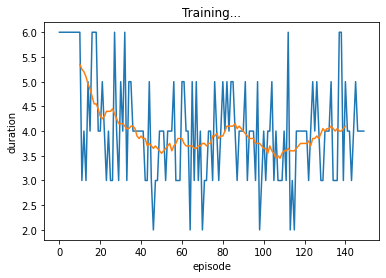

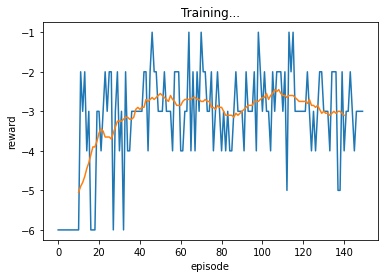

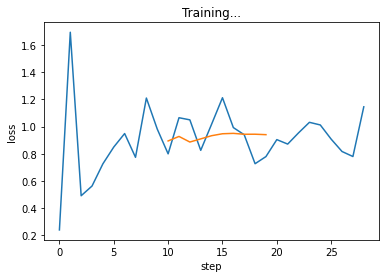

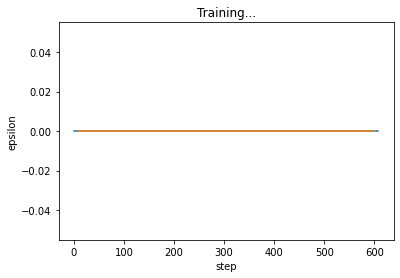

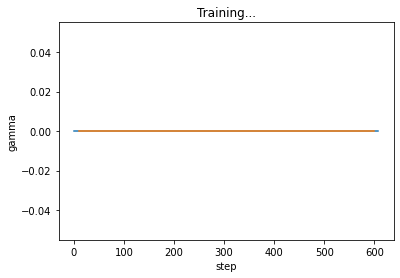

In [35]:

plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07),
    seed=0
    ))

pn params [Parameter containing:
tensor([[ 0.1377, -0.1180, -0.0518,  0.1254, -0.2516,  0.1603, -0.0550,  0.1360,
          0.0372, -0.0327,  0.0741,  0.0132,  0.0976, -0.1042]],
       requires_grad=True), Parameter containing:
tensor([-0.0195], requires_grad=True)]
=========================episode 0 nanny======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 11277 eerie [0.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 12760 tepee [0.         0.4        0.77777778 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12731 geese [0.         0.4        0.75896188 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 12668 belle [0.         0.4        0.67883212 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True

reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.25       0.4        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12794 mamma [0.4        0.         0.47137064 1.         0.        ]-------
reward -1 done True 
episode 8 finished.  reward -6  eps 0.0  gamma 0.0  steps 54  memory 48
mamma [0. 1. 0. 0. 0.] 1.0
eerie [0. 0. 1. 0. 2.] 2.0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 0.] 0
puppy [0. 1. 0. 0. 0.] 0
mamma [0. 1. 0. 0. 0.] 0
=========================episode 9 wispy======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 12514 rarer [0.         0.4        0.79626926 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 1279

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 11007 tiara [1.         0.4        0.69051095 0.33333333 0.        ]-------
reward -1 done False 
------guess 2 8189 shirr [1.         0.4        0.57210057 0.33333333 1.        ]-------
reward -1 done False 
------guess 3 11258 melee [0.         0.4        0.76788321 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 1728 cocco [0.25       0.4        0.47672344 1.         1.        ]-------
reward -1 done False 
------guess 5 313 anana [0.4        0.2        0.66293593 1.         1.        ]-------
reward -1 done True 
episode 11 finished.  reward -6  eps 0.0  gamma 0.0  steps 72  memory 66
eerie [0. 0. 1. 1. 0.] 2.0
tiara [0. 1. 0. 2. 0.] 1.0
shirr [2. 2. 2. 2. 0.] 5.0
melee [0. 0. 0. 0. 0.] 0
cocco [0. 0. 0. 0. 0.] 0
anana [0. 0. 0. 0. 0.] 0
=========================episode 12 flank======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 9014

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12514 rarer [0.         0.4        0.79626926 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 12266 salsa [0.         0.4        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11030 cacao [0.         0.4        0.5946472  0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11502 tatty [0.         0.4        0.58248175 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward -1 done True 
episode 14 finished.  reward -6  eps 0.0  gamma 0.0  steps 90  memory 84
mamma [0. 0. 0. 0. 0.] 0.0
rarer [0. 0. 0. 2. 0.] 2.0
salsa [0. 0. 0. 0. 0.] 0
cacao [0. 0. 0. 0. 1.] 0
tatty [0. 0. 0. 0. 2.] 0
mamma [0. 0. 0. 0. 0.] 0
=========================episode 15 lease======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 11

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11866 puppy [0.66666667 0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11776 emcee [0.5        0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12835 known [1.         0.6        0.37453366 0.33333333 0.        ]-------
reward 0 done True 
episode 17 finished.  reward -5  eps 0.0  gamma 0.0  steps 108  memory 102
eerie [0. 0. 0. 0. 0.] 0.0
salsa [0. 0. 0. 0. 0.] 0
tooth [0. 0. 2. 0. 0.] 2.0
puppy [0. 0. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 0.] 0
known [2. 2. 2. 2. 2.] 8.0
=========================episode 18 utile======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12204 whiff [0.         0.6        0.27818329 0.33333333 0.        ]-------
reward -1 done False 
------guess 2 12789 pygmy [0.         0.6        0.29910787 0.33333333 0.        ]-------
reward -1 done False 
------guess 3 11068 bobby [0.         0.4        0.32798054 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11386 savvy [0.         0.6        0.38588808 0.33333333 0.        ]-------
reward -1 done False 
------guess 5 12064 jerky [0.         0.8        0.45320357 0.         0.        ]-------
reward -1 done True 
episode 21 finished.  reward -6  eps 0.0  gamma 0.0  steps 125  memory 119
fuzzy [0. 0. 0. 0. 0.] 0.0
whiff [0. 1. 0. 0. 0.] 1.0
pygmy [0. 0. 0. 0. 0.] 0
bobby [2. 0. 0. 0. 0.] 1.0
savvy [0. 0. 0. 0. 0.] 0
jerky [0. 2. 2. 0. 0.] 2.0
=========================episode 22 weave======================
------guess 0 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
reward -1 done False 
------gues

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11866 puppy [0.33333333 0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11515 bongo [0.4        0.6        0.43390105 0.33333333 0.        ]-------
reward -1 done True 
episode 24 finished.  reward -6  eps 0.0  gamma 0.0  steps 143  memory 137
eerie [0. 0. 0. 0. 0.] 0.0
salsa [2. 0. 0. 0. 0.] 2.0
tooth [1. 0. 2. 0. 1.] 2.0
puppy [0. 1. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 0.] 0
bongo [0. 1. 0. 0. 0.] 0
=========================episode 25 faith======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12760 tepee [0.         0.4        0.77777778 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11258 melee [0.         0.4        0.76788321 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12731 geese [0.         0.4        0.75896188 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 10664 evade [0.         0.6        0.64736415 0.33333333 0.        ]-------
reward -1 done True 
episode 27 finished.  reward -6  eps 0.0  gamma 0.0  steps 161  memory 155
eerie [0. 0. 0. 0. 0.] 0.0
tepee [1. 0. 0. 0. 0.] 1.0
melee [0. 0. 0. 0. 0.] 0
geese [0. 0. 0. 1. 0.] 0
queue [0. 0. 0. 0. 0.] 0
evade [0. 0. 0. 0. 0.] 0
=========================episode 28 octet======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 10928 tease [1.         0.6        0.78556367 0.33333333 0.        ]-------
reward -1 done False 
------guess 2 12668 belle [1.         0.4        0.67883212 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11818 penne [1.         0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 4 12712 deuce [0.75       0.6        0.61686942 0.33333333 0.        ]-------
reward -1 done False 
------guess 5 12197 femme [0.6        0.4        0.53982157 0.66666667 0.        ]-------
reward -1 done True 
episode 30 finished.  reward -6  eps 0.0  gamma 0.0  steps 179  memory 173
eerie [0. 2. 0. 0. 2.] 4.0
tease [0. 2. 0. 0. 2.] 0
belle [0. 2. 0. 0. 2.] 0
penne [0. 2. 2. 0. 2.] 2.0
deuce [0. 2. 1. 0. 2.] 0
femme [0. 2. 0. 0. 2.] 0
=========================episode 31 honey======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11030 cacao [0.         0.4        0.5946472  0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12794 mamma [0.         0.2        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 4 11502 tatty [0.         0.4        0.58248175 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12044 kappa [0.         0.4        0.47072182 0.66666667 0.        ]-------
reward -1 done True 
episode 33 finished.  reward -6  eps 0.0  gamma 0.0  steps 197  memory 191
eerie [0. 0. 1. 0. 0.] 1.0
salsa [0. 0. 0. 0. 0.] 0
cacao [0. 0. 0. 0. 1.] 0
mamma [0. 0. 0. 0. 0.] 0
tatty [0. 0. 0. 0. 0.] 0
kappa [0. 0. 0. 0. 0.] 0
=========================episode 34 flora======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.         0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 36 finished.  reward -6  eps 0.0  gamma 0.0  steps 215  memory 209
eerie [0. 0. 0. 2. 0.] 2.0
salsa [2. 0. 0. 0. 0.] 0
tooth [1. 0. 2. 0. 0.] 1.0
emcee [0. 0. 1. 0. 0.] 0
penne [0. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 37 opera======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.         0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 39 finished.  reward -6  eps 0.0  gamma 0.0  steps 233  memory 227
eerie [0. 0. 1. 1. 0.] 2.0
salsa [1. 0. 0. 0. 0.] 0
tooth [0. 1. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 0.] 0
penne [0. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 40 privy======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.33333333 0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.25       0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12427 kneed [0.4        0.6        0.59107867 0.33333333 0.        ]-------
reward -1 done True 
episode 42 finished.  reward -6  eps 0.0  gamma 0.0  steps 251  memory 245
eerie [0. 2. 0. 2. 0.] 4.0
salsa [0. 0. 1. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
emcee [1. 0. 0. 0. 0.] 0
puppy [0. 0. 0. 0. 0.] 0
kneed [0. 0. 1. 0. 1.] 0
=========================episode 43 swami======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.         0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 45 finished.  reward -6  eps 0.0  gamma 0.0  steps 269  memory 263
eerie [0. 0. 0. 1. 0.] 1.0
salsa [2. 0. 0. 0. 0.] 1.0
tooth [0. 0. 0. 2. 2.] 2.0
emcee [0. 2. 0. 0. 0.] 0
penne [0. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 46 stink======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.         0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12427 kneed [0.2        0.6        0.59107867 0.33333333 0.        ]-------
reward -1 done True 
episode 48 finished.  reward -6  eps 0.0  gamma 0.0  steps 287  memory 281
eerie [0. 0. 0. 0. 2.] 2.0
salsa [2. 0. 1. 0. 0.] 1.0
tooth [1. 0. 2. 0. 0.] 0
emcee [0. 0. 0. 0. 2.] 0
puppy [0. 0. 0. 0. 0.] 0
kneed [0. 0. 1. 0. 0.] 0
=========================episode 49 these======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.33333333 0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.25       0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12427 kneed [0.4        0.6        0.59107867 0.33333333 0.        ]-------
reward -1 done True 
episode 51 finished.  reward -6  eps 0.0  gamma 0.0  steps 305  memory 299
eerie [0. 0. 0. 0. 2.] 2.0
salsa [0. 1. 1. 0. 1.] 1.0
tooth [0. 0. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 2.] 0
puppy [0. 0. 0. 0. 0.] 0
kneed [0. 0. 1. 0. 0.] 0
=========================episode 52 snipe======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.33333333 0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.5        0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12427 kneed [0.2        0.6        0.59107867 0.33333333 0.        ]-------
reward -1 done True 
episode 54 finished.  reward -6  eps 0.0  gamma 0.0  steps 323  memory 317
eerie [0. 0. 1. 0. 0.] 1.0
salsa [0. 0. 0. 0. 0.] 0
tooth [1. 0. 2. 0. 0.] 2.0
emcee [0. 0. 0. 0. 0.] 0
puppy [0. 1. 0. 0. 0.] 0
kneed [0. 0. 0. 0. 0.] 0
=========================episode 55 abort======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.33333333 0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.25       0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12427 kneed [0.2        0.6        0.59107867 0.33333333 0.        ]-------
reward -1 done True 
episode 57 finished.  reward -6  eps 0.0  gamma 0.0  steps 341  memory 335
eerie [0. 0. 0. 0. 2.] 2.0
salsa [0. 0. 1. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
emcee [0. 0. 2. 0. 2.] 2.0
puppy [0. 0. 0. 0. 1.] 0
kneed [0. 0. 1. 0. 0.] 0
=========================episode 58 upper======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.5        0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12427 kneed [0.         0.6        0.59107867 0.33333333 0.        ]-------
reward -1 done True 
episode 60 finished.  reward -6  eps 0.0  gamma 0.0  steps 359  memory 353
eerie [0. 0. 0. 0. 0.] 0.0
salsa [0. 2. 0. 0. 0.] 2.0
tooth [2. 0. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 0.] 0
puppy [0. 0. 0. 0. 2.] 0
kneed [0. 1. 0. 0. 0.] 0
=========================episode 61 trite======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.66666667 0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.5        0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12731 geese [0.4        0.2        0.75896188 0.66666667 0.        ]-------
reward -1 done True 
episode 63 finished.  reward -6  eps 0.0  gamma 0.0  steps 377  memory 371
eerie [0. 0. 1. 1. 2.] 4.0
salsa [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 2.] 0
puppy [0. 0. 0. 0. 0.] 0
geese [0. 0. 0. 0. 2.] 0
=========================episode 64 flair======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.25       0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12731 geese [0.2        0.2        0.75896188 0.66666667 0.        ]-------
reward -1 done True 
episode 66 finished.  reward -6  eps 0.0  gamma 0.0  steps 395  memory 389
eerie [0. 0. 0. 0. 0.] 0.0
salsa [2. 0. 0. 0. 0.] 2.0
tooth [0. 0. 2. 0. 0.] 0
emcee [0. 0. 1. 0. 0.] 0
puppy [0. 0. 0. 0. 0.] 0
geese [0. 0. 0. 1. 0.] 0
=========================episode 67 vague======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.         0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 69 finished.  reward -6  eps 0.0  gamma 0.0  steps 413  memory 407
eerie [0. 2. 0. 0. 0.] 2.0
mamma [0. 1. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 2.] 0
slyly [1. 1. 0. 0. 0.] 0
penne [0. 2. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 70 stout======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 72 finished.  reward -6  eps 0.0  gamma 0.0  steps 431  memory 425
eerie [0. 0. 0. 1. 0.] 1.0
mamma [0. 1. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 2. 0. 0. 0.] 1.0
penne [0. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 73 valet======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 11853 radar [1.         0.4        0.6729927  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 12821 rotor [0.5        0.4        0.65450122 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11258 melee [0.         0.4        0.76788321 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 8930 susus [0.25       0.4        0.47704785 1.         1.        ]-------
reward -1 done False 
------guess 5 313 anana [0.4        0.2        0.66293593 1.         1.        ]-------
reward -1 done True 
episode 75 finished.  reward -6  eps 0.0  gamma 0.0  steps 449  memory 443
eerie [0. 0. 1. 0. 0.] 1.0
radar [1. 1. 0. 1. 0.] 2.0
rotor [1. 1. 0. 0. 0.] 0
melee [0. 0. 0. 0. 0.] 0
susus [0. 0. 0. 0. 0.] 0
anana [2. 0. 0. 0. 2.] 1.0
=========================episode 76 grace======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 9

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 11277 eerie [0.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 78 finished.  reward -6  eps 0.0  gamma 0.0  steps 467  memory 461
mamma [0. 1. 0. 0. 0.] 1.0
eerie [0. 0. 0. 0. 2.] 1.0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 0. 0. 2. 0.] 0
penne [1. 0. 0. 0. 2.] 1.0
queue [0. 0. 0. 0. 2.] 0
=========================episode 79 gruff======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11866 puppy [1.         0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11776 emcee [0.5        0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12427 kneed [0.4        0.6        0.59107867 0.33333333 0.        ]-------
reward -1 done True 
episode 81 finished.  reward -6  eps 0.0  gamma 0.0  steps 485  memory 479
eerie [0. 0. 0. 0. 0.] 0.0
salsa [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
puppy [0. 2. 0. 0. 2.] 4.0
emcee [0. 1. 0. 0. 0.] 0
kneed [0. 0. 0. 0. 0.] 0
=========================episode 82 saucy======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 11277 eerie [0.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.         0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 84 finished.  reward -6  eps 0.0  gamma 0.0  steps 503  memory 497
mamma [0. 2. 0. 0. 0.] 2.0
eerie [0. 0. 2. 0. 0.] 0
tooth [0. 0. 0. 0. 1.] 0
slyly [0. 0. 0. 0. 2.] 0
penne [1. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 85 shoal======================
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 1 11

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.66666667 0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.5        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.4        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 87 finished.  reward -6  eps 0.0  gamma 0.0  steps 521  memory 515
eerie [2. 0. 0. 1. 0.] 3.0
salsa [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
emcee [2. 0. 0. 0. 0.] 0
penne [0. 1. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 88 perch======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 90 finished.  reward -6  eps 0.0  gamma 0.0  steps 539  memory 533
eerie [0. 0. 1. 0. 2.] 3.0
mamma [0. 1. 0. 0. 0.] 0
tooth [0. 0. 2. 0. 0.] 0
slyly [0. 0. 0. 0. 0.] 0
penne [0. 0. 0. 0. 2.] 0
queue [0. 0. 0. 0. 2.] 0
=========================episode 91 blame======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 12

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.33333333 0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.4        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 93 finished.  reward -6  eps 0.0  gamma 0.0  steps 557  memory 551
eerie [1. 1. 0. 0. 0.] 2.0
salsa [0. 0. 1. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
emcee [1. 0. 0. 2. 0.] 1.0
penne [1. 1. 0. 0. 1.] 0
queue [0. 0. 2. 0. 1.] 0
=========================episode 94 rural======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.66666667 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 96 finished.  reward -6  eps 0.0  gamma 0.0  steps 575  memory 569
eerie [0. 0. 0. 0. 0.] 0.0
mamma [0. 0. 0. 0. 0.] 0
tooth [1. 0. 0. 0. 0.] 1.0
slyly [2. 0. 0. 0. 0.] 1.0
penne [0. 0. 0. 0. 0.] 0
queue [0. 1. 0. 0. 0.] 0
=========================episode 97 bound======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12794 mamma [0.66666667 0.2        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.5        0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12731 geese [0.2        0.2        0.75896188 0.66666667 0.        ]-------
reward -1 done True 
episode 99 finished.  reward -6  eps 0.0  gamma 0.0  steps 593  memory 587
eerie [0. 0. 0. 0. 0.] 0.0
salsa [0. 1. 0. 0. 2.] 3.0
tooth [0. 0. 0. 0. 0.] 0
mamma [0. 1. 0. 0. 2.] 0
puppy [0. 2. 0. 0. 0.] 0
geese [2. 0. 0. 0. 0.] 0
=========================episode 100 delta======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.5        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.4        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 102 finished.  reward -6  eps 0.0  gamma 0.0  steps 611  memory 605
eerie [0. 0. 1. 0. 0.] 1.0
mamma [0. 1. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 0.] 0
penne [0. 0. 0. 2. 0.] 1.0
queue [0. 0. 0. 0. 0.] 0
=========================episode 103 rainy======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12266 salsa [0.         0.6        0.6512571  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 11776 emcee [0.         0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11866 puppy [0.25       0.6        0.32327656 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 12731 geese [0.2        0.2        0.75896188 0.66666667 0.        ]-------
reward -1 done True 
episode 105 finished.  reward -6  eps 0.0  gamma 0.0  steps 629  memory 623
eerie [0. 0. 0. 1. 0.] 1.0
salsa [0. 2. 0. 2. 0.] 3.0
tooth [1. 0. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 0.] 0
puppy [0. 0. 0. 0. 0.] 0
geese [0. 0. 0. 2. 0.] 0
=========================episode 106 verve======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 108 finished.  reward -6  eps 0.0  gamma 0.0  steps 647  memory 641
eerie [0. 2. 0. 1. 0.] 3.0
mamma [0. 0. 0. 0. 0.] 0
tooth [1. 0. 0. 0. 1.] 0
slyly [1. 0. 0. 0. 0.] 0
penne [0. 2. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 109 mouse======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.66666667 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 111 finished.  reward -6  eps 0.0  gamma 0.0  steps 665  memory 659
eerie [0. 0. 0. 0. 0.] 0.0
mamma [0. 1. 0. 2. 2.] 5.0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 2. 0. 1. 0.] 0
penne [0. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 112 brood======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 114 finished.  reward -6  eps 0.0  gamma 0.0  steps 683  memory 677
eerie [1. 0. 0. 0. 0.] 1.0
mamma [0. 2. 2. 0. 0.] 3.0
tooth [0. 1. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 0.] 0
penne [0. 1. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 115 civil======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.         0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.         0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 117 finished.  reward -6  eps 0.0  gamma 0.0  steps 701  memory 695
eerie [0. 0. 1. 0. 0.] 1.0
mamma [0. 1. 0. 0. 0.] 0
tooth [2. 0. 0. 0. 2.] 3.0
slyly [1. 0. 0. 0. 0.] 0
penne [0. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 118 alloy======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 11853 radar [1.         0.4        0.6729927  0.66666667 0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11776 emcee [0.25       0.4        0.72862936 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11818 penne [0.2        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done True 
episode 120 finished.  reward -6  eps 0.0  gamma 0.0  steps 719  memory 713
eerie [0. 0. 1. 0. 0.] 1.0
radar [1. 0. 0. 0. 0.] 0
tooth [0. 0. 2. 0. 0.] 1.0
slyly [0. 0. 0. 0. 0.] 0
emcee [0. 0. 0. 0. 0.] 0
penne [2. 0. 0. 2. 0.] 2.0
=========================episode 121 spank======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------gues

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.66666667 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.5        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.4        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 123 finished.  reward -6  eps 0.0  gamma 0.0  steps 737  memory 731
eerie [1. 0. 1. 1. 0.] 3.0
mamma [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 1. 0. 0. 0.] 0
penne [0. 1. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 124 trace======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 126 finished.  reward -6  eps 0.0  gamma 0.0  steps 755  memory 749
eerie [0. 2. 0. 0. 0.] 2.0
mamma [0. 1. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 2.] 0
penne [0. 2. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 127 large======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 129 finished.  reward -6  eps 0.0  gamma 0.0  steps 773  memory 767
eerie [1. 0. 0. 0. 0.] 1.0
mamma [0. 0. 0. 0. 0.] 0
tooth [1. 0. 0. 0. 0.] 0
slyly [1. 0. 0. 0. 0.] 0
penne [0. 1. 0. 0. 0.] 0
queue [0. 2. 2. 0. 0.] 3.0
=========================episode 130 slick======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.66666667 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 132 finished.  reward -6  eps 0.0  gamma 0.0  steps 791  memory 785
eerie [0. 0. 0. 0. 0.] 0.0
mamma [0. 0. 0. 0. 0.] 0
tooth [1. 0. 0. 0. 1.] 2.0
slyly [2. 0. 0. 0. 0.] 0
penne [0. 0. 0. 2. 0.] 0
queue [0. 1. 0. 0. 0.] 0
=========================episode 133 terra======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [1.         0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.5        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.4        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 135 finished.  reward -6  eps 0.0  gamma 0.0  steps 809  memory 803
eerie [0. 0. 0. 0. 0.] 0.0
mamma [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
slyly [1. 0. 1. 0. 2.] 4.0
penne [1. 0. 0. 0. 0.] 0
queue [0. 0. 0. 0. 0.] 0
=========================episode 136 dodgy======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.5        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.4        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 138 finished.  reward -6  eps 0.0  gamma 0.0  steps 827  memory 821
eerie [1. 0. 1. 0. 0.] 2.0
mamma [0. 0. 0. 0. 0.] 0
tooth [0. 2. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 0.] 0
penne [2. 1. 0. 0. 0.] 1.0
queue [0. 0. 1. 0. 0.] 0
=========================episode 139 truce======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12731 geese [0.33333333 0.4        0.75896188 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 12668 belle [0.25       0.4        0.67883212 0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11818 penne [0.2        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done True 
episode 141 finished.  reward -6  eps 0.0  gamma 0.0  steps 845  memory 839
eerie [0. 0. 0. 1. 2.] 3.0
mamma [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 2. 0.] 0
geese [0. 0. 0. 1. 2.] 0
belle [0. 0. 0. 0. 2.] 0
penne [1. 0. 0. 0. 2.] 0
=========================episode 142 train======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.66666667 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.5        0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.4        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 144 finished.  reward -6  eps 0.0  gamma 0.0  steps 863  memory 857
eerie [0. 2. 2. 0. 0.] 4.0
mamma [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 0.] 0
slyly [0. 0. 0. 0. 2.] 0
penne [0. 2. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 145 bossy======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


reward -1 done False 
------guess 1 12794 mamma [0.         0.4        0.47137064 1.         0.        ]-------
reward -1 done False 
------guess 2 11842 tooth [0.5        0.6        0.54420114 0.66666667 0.        ]-------
reward -1 done False 
------guess 3 12695 slyly [0.33333333 0.6        0.47964315 0.66666667 0.        ]-------
reward -1 done False 
------guess 4 11818 penne [0.25       0.4        0.6460665  0.66666667 0.        ]-------
reward -1 done False 
------guess 5 11456 queue [0.2        0.4        0.55620438 0.66666667 0.        ]-------
reward -1 done True 
episode 147 finished.  reward -6  eps 0.0  gamma 0.0  steps 881  memory 875
eerie [1. 0. 2. 0. 0.] 3.0
mamma [0. 0. 0. 0. 0.] 0
tooth [0. 0. 0. 0. 1.] 0
slyly [2. 0. 0. 0. 0.] 0
penne [0. 1. 0. 0. 0.] 0
queue [0. 0. 1. 0. 0.] 0
=========================episode 148 clean======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward -1 done False 
------guess 1 

/home/gordon/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


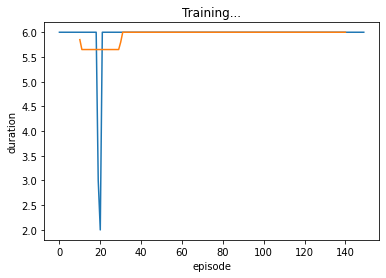

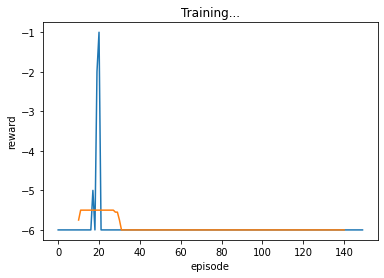

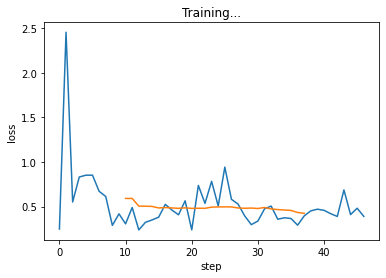

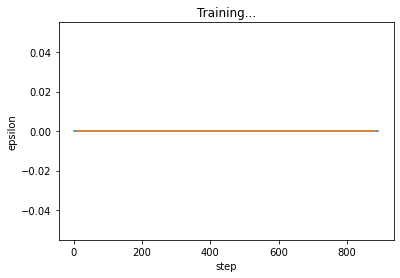

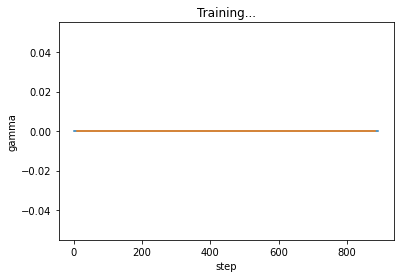

In [11]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07),
    seed=1))